# Import packages

In [1]:
import pandas as pd
from pandas import datetime
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

# Import data and basic Statistics

In [2]:
#Import original data
sales_prom=pd.read_csv("train_assignment/Total Monthly Sales-Selected SKUs.csv")

In [3]:
#Visualize the head
sales_prom.head()

,YearMonth,SKU_01,SKU_02,SKU_03,SKU_04,SKU_05
0,201301,54268.71859,50138.16706,55565.89378,78958.36939,57926.08905
1,201302,54538.72314,52485.26584,56150.35574,80920.91870,58560.93175
2,201303,55770.18576,53597.28964,61014.84901,83087.52438,59939.71629
3,201304,57726.54491,56186.19213,60914.60851,85532.56629,62214.63822
4,201305,57664.36698,55647.34245,60791.61941,86497.57689,62940.98444


In [4]:
#Obtain the dates
months = list(sales_prom['YearMonth'].values)
months=[str(x) for x in months]
months = [x[:4]+str('-')+x[4:] for x in months]
months[0:10]

['2013-01',
 '2013-02',
 '2013-03',
 '2013-04',
 '2013-05',
 '2013-06',
 '2013-07',
 '2013-08',
 '2013-09',
 '2013-10']

In [5]:
#Convert dates into datetime format and ad as index to the dataframe, then visualize the head
sales_prom['YearMonth'] = months
sales_prom['YearMonth'] = pd.to_datetime(sales_prom.YearMonth,format='%Y-%m')
sales_prom = sales_prom.set_index('YearMonth')
sales_prom.head()

,SKU_01,SKU_02,SKU_03,SKU_04,SKU_05
YearMonth,,,,,
2013-01-01,54268.71859,50138.16706,55565.89378,78958.36939,57926.08905
2013-02-01,54538.72314,52485.26584,56150.35574,80920.91870,58560.93175
2013-03-01,55770.18576,53597.28964,61014.84901,83087.52438,59939.71629
2013-04-01,57726.54491,56186.19213,60914.60851,85532.56629,62214.63822
2013-05-01,57664.36698,55647.34245,60791.61941,86497.57689,62940.98444


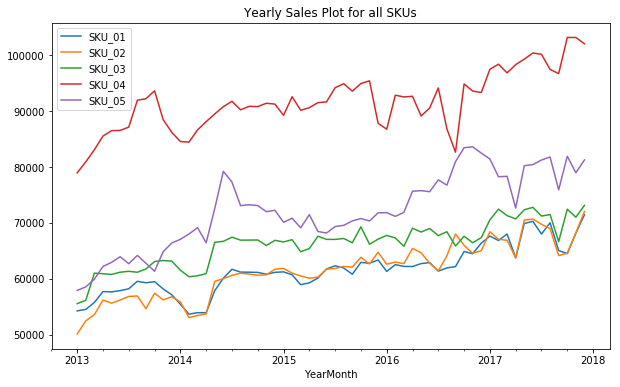

In [6]:
#Plot original data for all SKUs
plt.rcParams['figure.figsize'] = [10, 6]
sales_prom.plot(title = 'Yearly Sales Plot for all SKUs')

In [7]:
#Visualize sku names
sku = sales_prom.columns.values
sku

array(['SKU_01', 'SKU_02', 'SKU_03', 'SKU_04', 'SKU_05'], dtype=object)


# Function Definitions


In [8]:
#Calculate rolling statistics
def calcRollStats(df,val):
    #determining rolling statistics
    rollmean = df.rolling(window = 12).mean()
    rollstd = df.rolling(window = 12).std()
    return rollmean,rollstd

In [9]:
#Plot basic stats of rolling mean and rolling std for the data
def plotStats(df,val):
    rollmean,rollstd = calcRollStats(df,val)
    orig = plt.plot(df, color = 'blue',label = 'Original')
    mean = plt.plot(rollmean, color = 'red',label = 'Rolling Mean')
    std = plt.plot(rollstd, color = 'black',label = 'Rolling Std')

    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation for '+ val)
    plt.show(block = False)

In [10]:
#Check for stationarity with the Dickey-Fuller test
def ADfullerTest(df,val):
    #Performing Dickey-Fuller Test
    print('Results from the Dickey-Fuller Test for ' + val)
    dftest = adfuller(df[val], autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

    if(max(dfoutput[[0,4,5,6]]))!=dfoutput[0] and dfoutput[1]<=0.5:
            print('\nThe dataset is stationary')
    else:
        print('\nNot stationary')

In [11]:
#Transform data and get rolling mean and rolling std, with plots
def LogTransformedStatsWithPlots(df,val):
    #Estimating trend
    df_logScale = np.log(df)
    
    #determining rolling statistics
    movingAverage = df_logScale.rolling(window = 12).mean()

    movingSTD = df_logScale.rolling(window = 12).std()
    
    orig = plt.plot(df_logScale, color = 'blue',label = 'Original')
    mean = plt.plot(movingAverage, color = 'red',label = 'Rolling Mean')
    plt.legend(loc = 'best')
    plt.title('Log Transformed Rolling Mean for '+ val)
    plt.show(block = False)
    print('\n')
    return df_logScale,movingAverage

In [12]:
#Transform data and get rolling mean and rolling std
def LogTransformedStats(df,val):
    #Estimating trend
    df_logScale = np.log(df)
    
    #determining rolling statistics
    movingAverage = df_logScale.rolling(window = 12).mean()

    movingSTD = df_logScale.rolling(window = 12).std()
    return df_logScale,movingAverage

In [13]:
##Calculate difference of data with it's shifted version of degree = 1, with plots
def diffShiftWithPlots(df,val):
    df_diffShift = df - df.shift()
    df_diffShift.dropna(inplace = True)
    plt.plot(df_diffShift)
    
    plt.title('Difference between self and Lag = 1 for '+ val)
    plt.show(block = False)
    return df_diffShift

In [14]:
#Calculate difference of data with it's shifted version of degree = 1
def diffShift(df,val):
    df_diffShift = df - df.shift()
    df_diffShift.dropna(inplace = True)
    return df_diffShift

In [15]:
#Get seasonality, trend and residuals of the transformed data
def seasonalplots(df,val):
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(df)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    print('\n***** Seasonality, trend check plots for Log transformed '+ val +' *****\n')
    
    plt.subplot(411)
    plt.plot(df, label = 'Original')
    plt.legend(loc = 'best')

    plt.subplot(412)
    plt.plot(trend, label = 'Trend')
    plt.legend(loc = 'best')

    plt.subplot(413)
    plt.plot(seasonal, label = 'Seasonality')
    plt.legend(loc = 'best')

    plt.subplot(414)
    plt.plot(residual, label = 'Residuals')
    plt.legend(loc = 'best')
    plt.tight_layout()
    
    plt.show(block = False)
    
    decomposedLgDf = residual
    decomposedLgDf.dropna(inplace = True)
    ADfullerTest(decomposedLgDf,val)

In [16]:
#ARIMA model with the best parameters
def ARIMA_Model(df,df_diffShift,val):
    import itertools
    p=d=q=range(0,6)
    pdq = list(itertools.product(p,d,q))
    
    import warnings
    warnings.filterwarnings('ignore')
    list_param = []
    list_aic = []
    for param in pdq:
        try:
            model_arima = ARIMA(df,order=param)
            model_arima_fit = model_arima.fit()
            list_param.append(param)
            list_aic.append(model_arima_fit.aic)
    #         print(param,model_arima_fit.aic)
        except:
            continue
    min_val = min(list_aic)
    min_ind = list_aic.index(min_val)
    
    print("\n********** ARIMA Model for Log Transformed Data of " +val+' **********\n')
    
    print("\nBest (p, d, q) Parameters: "+str(list_param[min_ind]))
    
    model = ARIMA(df, order = (list_param[min_ind]))
    model_fit = model.fit()

    print("\nAIC Value: " +  str(model_fit.aic))
       
    print("\n*** RSS Plot between fitted model and shifted difference of Log Transform for " +val+'***\n')
    plt.plot(df_diffShift[val].values)
    plt.plot(model_fit.fittedvalues.values, color = 'red')
    plt.title('RSS: %.4f' % sum((model_fit.fittedvalues - df_diffShift[val])**2))
    plt.show(block = False)
    return model_fit

In [17]:
#Obtain plots of fitted data
def fittedPlots(df_main,df,val,model_fit):
    predictions_diff = pd.Series(model_fit.fittedvalues,copy = True)
    predictions_diff_cumsum = predictions_diff.cumsum()
    
    predictions_log = pd.Series(df[val].ix[0],index=df.index)
    predictions_log = predictions_log.add(predictions_diff_cumsum,fill_value=0)
    
    predictions = np.exp(predictions_log)
    
    
    plt.plot(df_main[val])
    plt.plot(predictions)
    
    plt.show(block = False)

In [18]:
#Predict forecast of transformed data
def forecastPlots(model_fit,val,months):     
    model_fit.plot_predict(1,60+months)
    
    #Values of the forecast
    forecast_val = model_fit.forecast(steps = months)
    
    return forecast_val

In [30]:
#Predict sales forecast
def forecastInContinuity(df_main,forecast_val,val, months):
    forecast_val_proper = np.exp(forecast_val)
    
    current = df_main.index[-1]
    new = []
    for i in range(0,len(forecast_val_proper)):
        next_month = str(current.year + (current.month // 12))+'-'+str(((current.month % 12) + 1)) +'-01'
        next_month = pd.to_datetime(next_month,format='%Y-%m')
        current = next_month
        new.append(next_month.strftime("%Y-%m"))
        
    forecast_df = pd.DataFrame({val :forecast_val_proper,'YearMonth':new})
    forecast_df.set_index('YearMonth',inplace = True)
    forecast_df.index = pd.to_datetime(forecast_df.index)
    
    final = sales_prom[val].append(forecast_df)
    final.columns = [val,'Forecast']
    
    final.plot(title = str(months//12)+" Year Forecast for " +val+' in continuity')

In [20]:
#EDA plots and visualizations
def EDA(data,sku):
    plt.rcParams['figure.figsize'] = [10, 6]
    for val in sku:
        df = pd.DataFrame(data[val])
        print('\n********** Stats of ' + val +' **********\n')
        plotStats(df,val)
        ADfullerTest(df,val)
        df_logScale,movingAverage = LogTransformedStatsWithPlots(df,val)
        
        df_diff = df_logScale - movingAverage
        #Remove NaN values
        df_diff.dropna(inplace = True)
        print('*** Difference of Log Transformed ' + val +' and rolling mean ***\n')
        plotStats(df_diff,val)
        ADfullerTest(df_diff,val)
        
        print('\n*** Stats of Difference of Log Transformed self and lag = 1 for ' + val +' ***\n')
        df_diffShift = pd.DataFrame(diffShiftWithPlots(df_logScale,val))
        ADfullerTest(df_diffShift,val)
        
        seasonalplots(df_logScale,val)

In [21]:
def ARIMAtesting(data,sku):
    plt.rcParams['figure.figsize'] = [10, 6]
    models_fit = []
    for val in sku:
        df = pd.DataFrame(data[val])
        df_logScale,movingAverage = LogTransformedStats(df,val)
        
        df_diffShift = pd.DataFrame(diffShift(df_logScale,val))
        
        model_fit = ARIMA_Model(df_logScale,df_diffShift,val)
        
        models_fit.append(model_fit)
    
    return models_fit

In [22]:
#Plot the fitted model
def fittedmodelsPlots(data,sku,models_fit):
    plt.rcParams['figure.figsize'] = [10, 6]
    
    df1 = pd.DataFrame(data[sku[0]])    
    df1_logScale,df1_movingAverage = LogTransformedStats(df1,sku[0])
    fittedPlots(df1,df1_logScale,sku[0],models_fit[0])

    df2 = pd.DataFrame(data[sku[1]])    
    df2_logScale,df2_movingAverage = LogTransformedStats(df2,sku[1])
    fittedPlots(df2,df2_logScale,sku[1],models_fit[1])

    df3 = pd.DataFrame(data[sku[2]])    
    df3_logScale,df3_movingAverage = LogTransformedStats(df3,sku[2])
    fittedPlots(df3,df3_logScale,sku[2],models_fit[2])

    df4 = pd.DataFrame(data[sku[3]])    
    df4_logScale,df4_movingAverage = LogTransformedStats(df4,sku[3])
    fittedPlots(df4,df4_logScale,sku[3],models_fit[3])

    df5 = pd.DataFrame(data[sku[4]])    
    df5_logScale,df5_movingAverage = LogTransformedStats(df5,sku[4])
    fittedPlots(df5,df5_logScale,sku[4],models_fit[4])

In [31]:
#Predict forecast of the transformed data for all SKU
def forecasts(models_fit,sku,months):
    plt.rcParams['figure.figsize'] = [10, 6]
    
    months = months
    
    print("\n********** " + str(months//12) + " Year Forecast for the Log Transformed SKUs **********\n")
          
    forecast1_val = forecastPlots(models_fit[0],sku[0],months)

    forecast2_val = forecastPlots(models_fit[1],sku[1],months)

    forecast3_val = forecastPlots(models_fit[2],sku[2],months)

    forecast4_val = forecastPlots(models_fit[3],sku[3],months)

    forecast5_val = forecastPlots(models_fit[4],sku[4],months)

    return forecast1_val[0],forecast2_val[0],forecast3_val[0],forecast4_val[0],forecast5_val[0], months

In [24]:
#Predict final sales forecast for all SKUs
def finalForecasts(data,sku,forecasts_list, months):
    df1 = pd.DataFrame(data[sku[0]])  
    forecastInContinuity(df1,forecasts_list[0],sku[0], months)
    
    df2 = pd.DataFrame(data[sku[1]])  
    forecastInContinuity(df2,forecasts_list[1],sku[1], months)
    
    df3 = pd.DataFrame(data[sku[2]])  
    forecastInContinuity(df3,forecasts_list[2],sku[2], months)
    
    df4 = pd.DataFrame(data[sku[3]])  
    forecastInContinuity(df4,forecasts_list[3],sku[3], months)

    df5 = pd.DataFrame(data[sku[4]])  
    forecastInContinuity(df5,forecasts_list[4],sku[4], months)


# Results



## Exploratory Data Analysis



********** Stats of SKU_01 **********



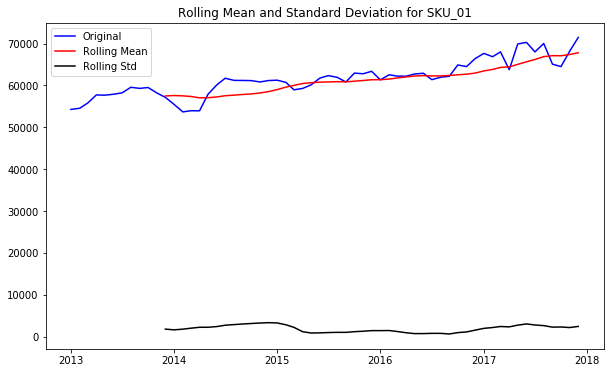

Results from the Dickey-Fuller Test for SKU_01
Test Statistic                 -1.283841
p-value                         0.636532
#Lags Used                      0.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64

Not stationary


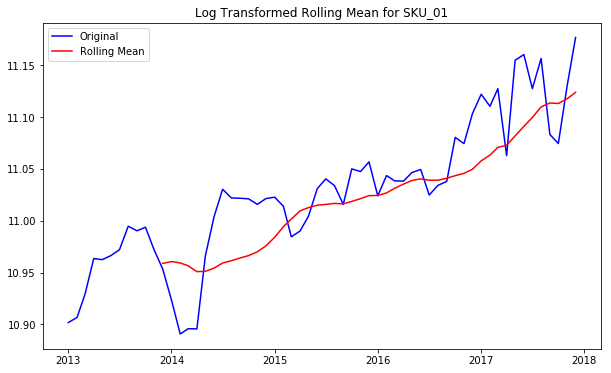



*** Difference of Log Transformed SKU_01 and rolling mean ***



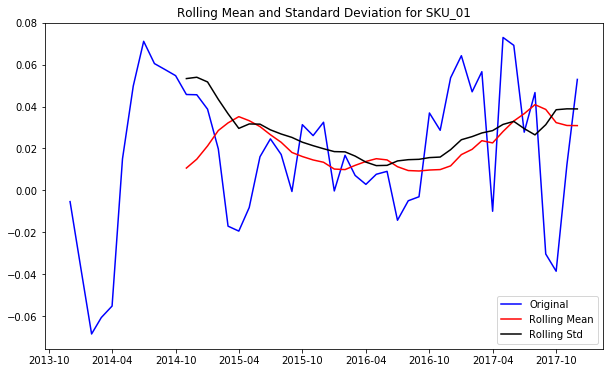

Results from the Dickey-Fuller Test for SKU_01
Test Statistic                 -3.050562
p-value                         0.030435
#Lags Used                      0.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64

The dataset is stationary

*** Stats of Difference of Log Transformed self and lag = 1 for SKU_01 ***



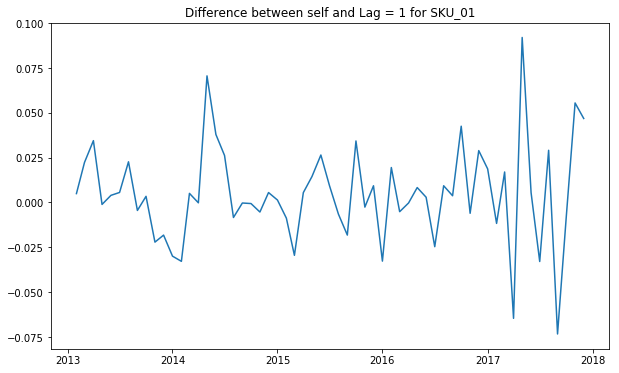

Results from the Dickey-Fuller Test for SKU_01
Test Statistic                 -5.321186
p-value                         0.000005
#Lags Used                      3.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64

The dataset is stationary

***** Seasonality, trend check plots for Log transformed SKU_01 *****



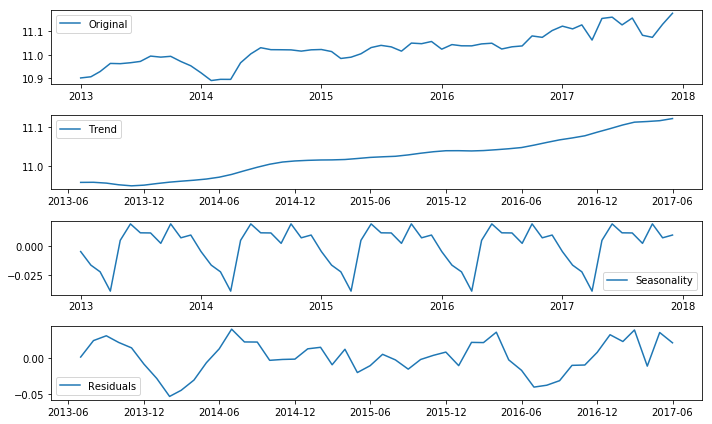

Results from the Dickey-Fuller Test for SKU_01
Test Statistic                 -4.459918
p-value                         0.000232
#Lags Used                      2.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64

The dataset is stationary

********** Stats of SKU_02 **********



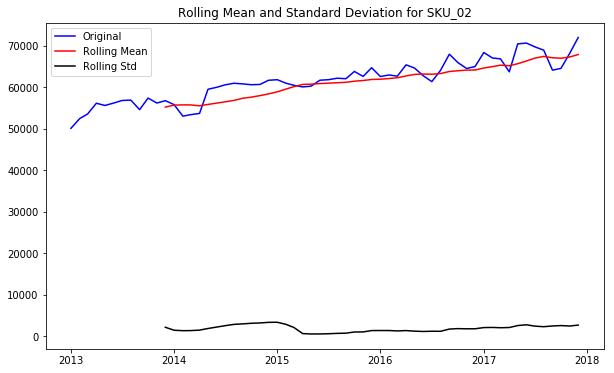

Results from the Dickey-Fuller Test for SKU_02
Test Statistic                 -0.973331
p-value                         0.762866
#Lags Used                      3.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64

Not stationary


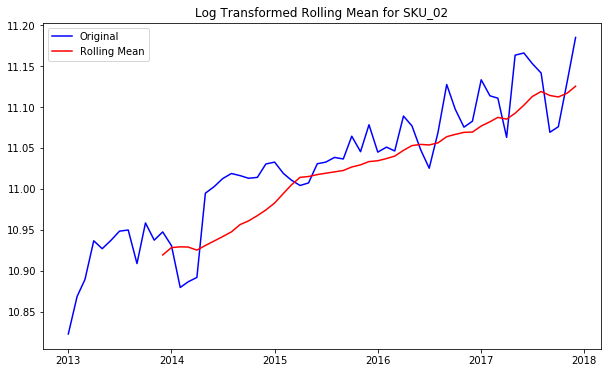



*** Difference of Log Transformed SKU_02 and rolling mean ***



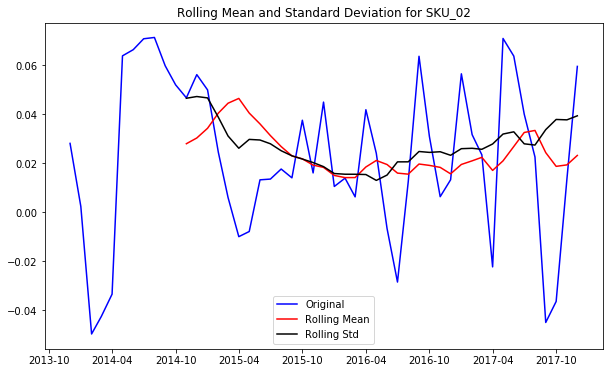

Results from the Dickey-Fuller Test for SKU_02
Test Statistic                 -3.307676
p-value                         0.014539
#Lags Used                      3.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64

The dataset is stationary

*** Stats of Difference of Log Transformed self and lag = 1 for SKU_02 ***



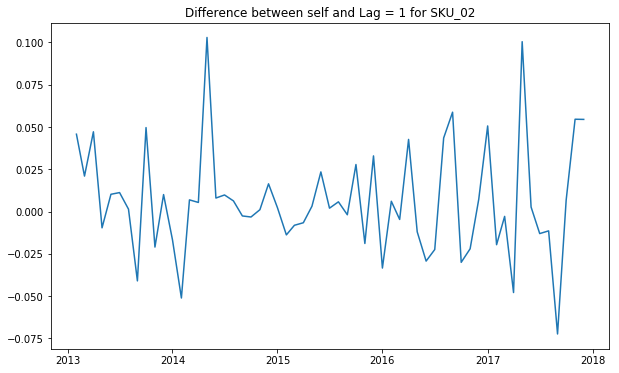

Results from the Dickey-Fuller Test for SKU_02
Test Statistic                -7.315511e+00
p-value                        1.232310e-10
#Lags Used                     2.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64

The dataset is stationary

***** Seasonality, trend check plots for Log transformed SKU_02 *****



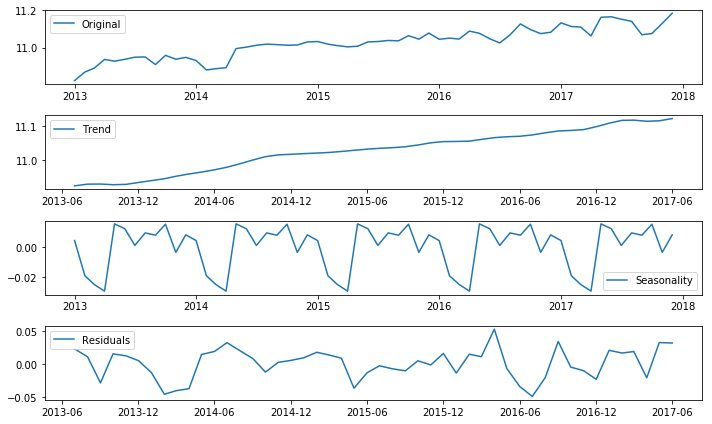

Results from the Dickey-Fuller Test for SKU_02
Test Statistic                 -4.107334
p-value                         0.000942
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64

The dataset is stationary

********** Stats of SKU_03 **********



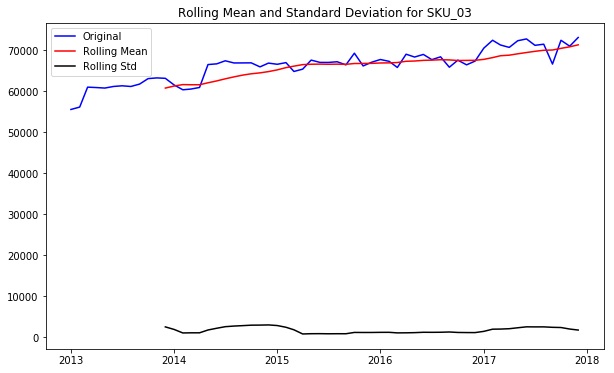

Results from the Dickey-Fuller Test for SKU_03
Test Statistic                 -2.393437
p-value                         0.143597
#Lags Used                      1.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64

Not stationary


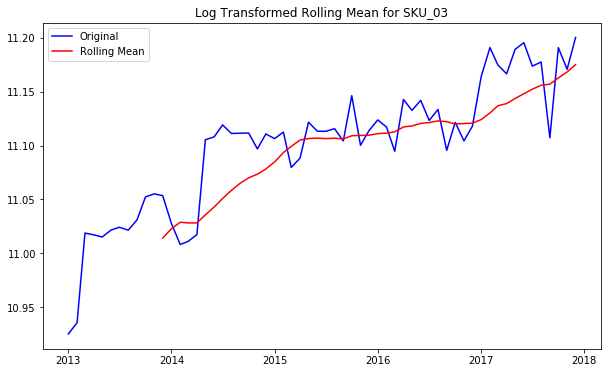



*** Difference of Log Transformed SKU_03 and rolling mean ***



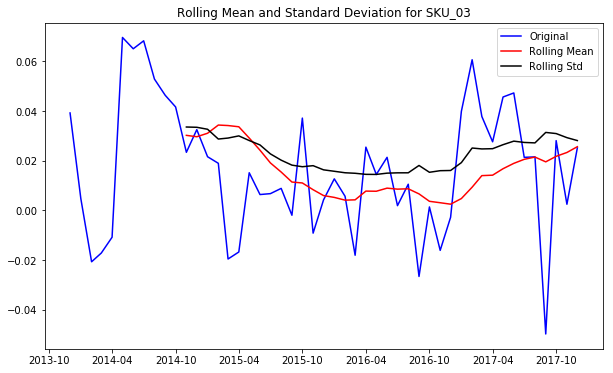

Results from the Dickey-Fuller Test for SKU_03
Test Statistic                 -4.276809
p-value                         0.000487
#Lags Used                      0.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64

The dataset is stationary

*** Stats of Difference of Log Transformed self and lag = 1 for SKU_03 ***



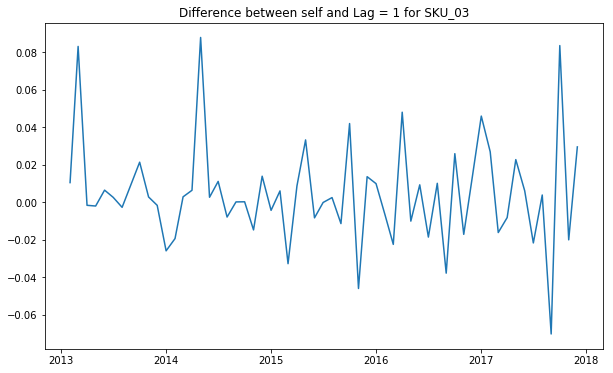

Results from the Dickey-Fuller Test for SKU_03
Test Statistic                -1.015042e+01
p-value                        7.978166e-18
#Lags Used                     0.000000e+00
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64

The dataset is stationary

***** Seasonality, trend check plots for Log transformed SKU_03 *****



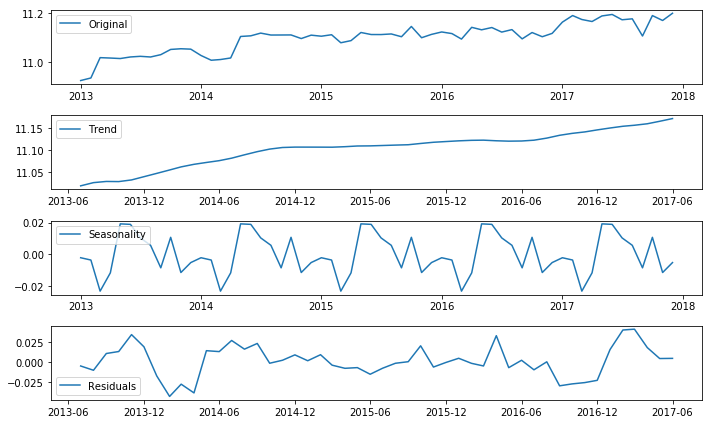

Results from the Dickey-Fuller Test for SKU_03
Test Statistic                 -4.891131
p-value                         0.000036
#Lags Used                      2.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64

The dataset is stationary

********** Stats of SKU_04 **********



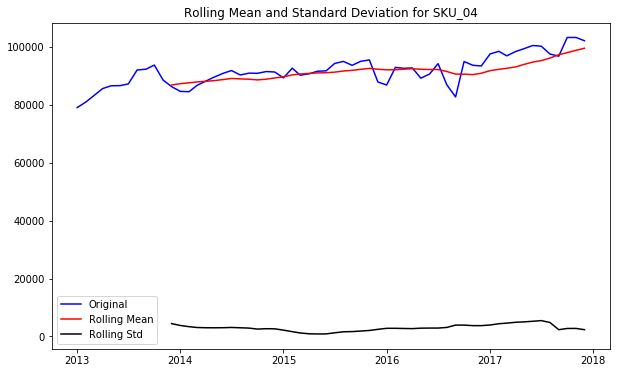

Results from the Dickey-Fuller Test for SKU_04
Test Statistic                 -1.428191
p-value                         0.568689
#Lags Used                      2.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64

Not stationary


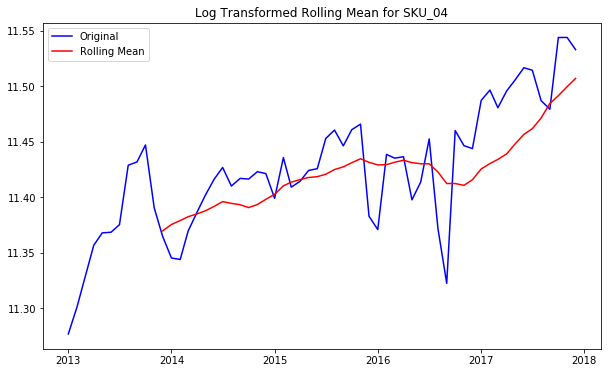



*** Difference of Log Transformed SKU_04 and rolling mean ***



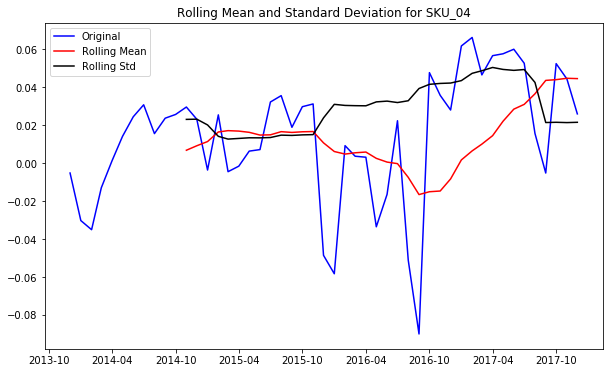

Results from the Dickey-Fuller Test for SKU_04
Test Statistic                 -2.292043
p-value                         0.174547
#Lags Used                      2.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64

Not stationary

*** Stats of Difference of Log Transformed self and lag = 1 for SKU_04 ***



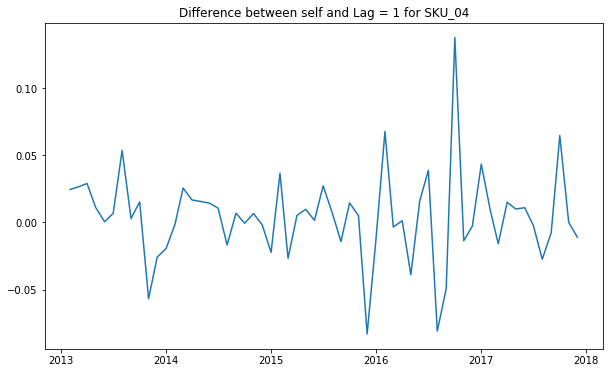

Results from the Dickey-Fuller Test for SKU_04
Test Statistic                -8.336698e+00
p-value                        3.257805e-13
#Lags Used                     1.000000e+00
Number of Observations Used    5.700000e+01
Critical Value (1%)           -3.550670e+00
Critical Value (5%)           -2.913766e+00
Critical Value (10%)          -2.594624e+00
dtype: float64

The dataset is stationary

***** Seasonality, trend check plots for Log transformed SKU_04 *****



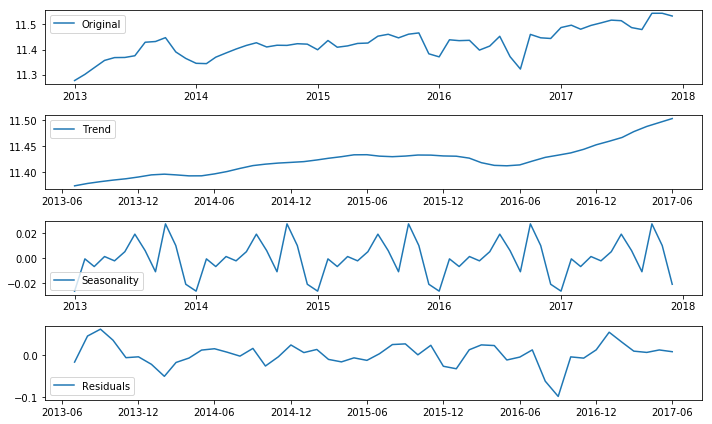

Results from the Dickey-Fuller Test for SKU_04
Test Statistic                 -5.237326
p-value                         0.000007
#Lags Used                      3.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64

The dataset is stationary

********** Stats of SKU_05 **********



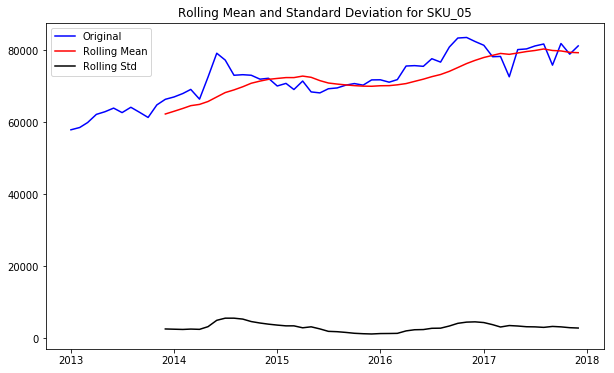

Results from the Dickey-Fuller Test for SKU_05
Test Statistic                 -1.988202
p-value                         0.291770
#Lags Used                      0.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64

Not stationary


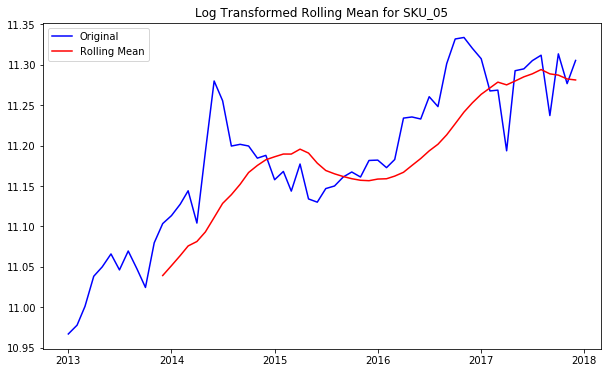



*** Difference of Log Transformed SKU_05 and rolling mean ***



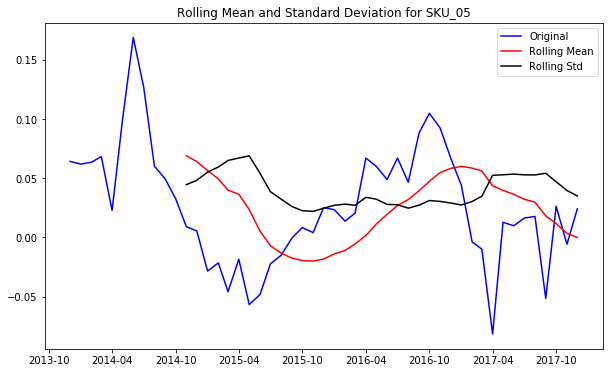

Results from the Dickey-Fuller Test for SKU_05
Test Statistic                 -2.504472
p-value                         0.114390
#Lags Used                      5.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64

Not stationary

*** Stats of Difference of Log Transformed self and lag = 1 for SKU_05 ***



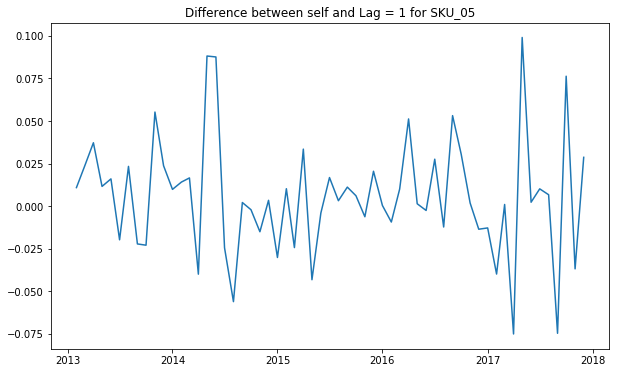

Results from the Dickey-Fuller Test for SKU_05
Test Statistic                -9.349340e+00
p-value                        8.377624e-16
#Lags Used                     0.000000e+00
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64

The dataset is stationary

***** Seasonality, trend check plots for Log transformed SKU_05 *****



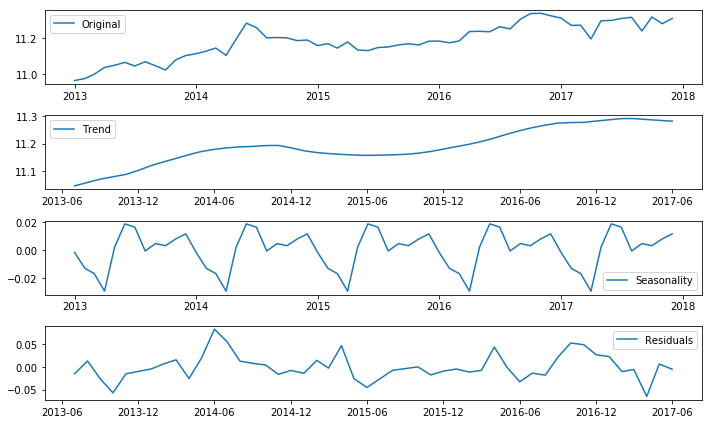

Results from the Dickey-Fuller Test for SKU_05
Test Statistic                 -4.406296
p-value                         0.000289
#Lags Used                      0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64

The dataset is stationary


In [25]:
#Visualize EDA
EDA(sales_prom,sku)


## ARIMA Modeling



********** ARIMA Model for Log Transformed Data of SKU_01 **********


Best (p, d, q) Parameters: (0, 1, 4)

AIC Value: -257.71689205430357

*** RSS Plot between fitted model and shifted difference of Log Transform for SKU_01***



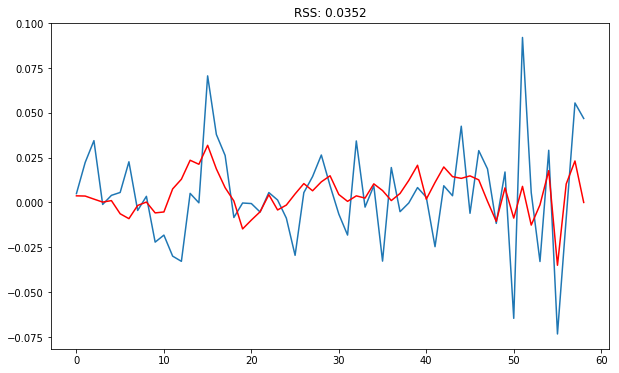


********** ARIMA Model for Log Transformed Data of SKU_02 **********


Best (p, d, q) Parameters: (0, 1, 3)

AIC Value: -245.25317800486013

*** RSS Plot between fitted model and shifted difference of Log Transform for SKU_02***



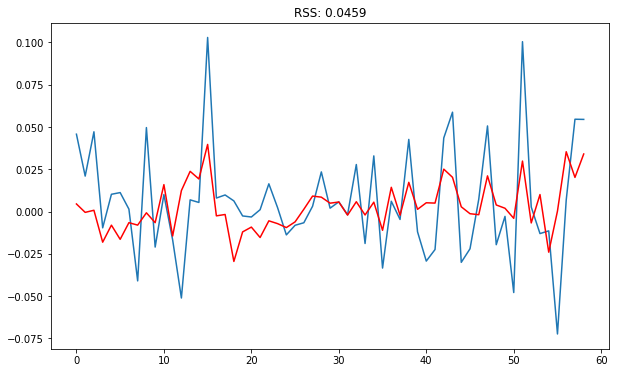


********** ARIMA Model for Log Transformed Data of SKU_03 **********


Best (p, d, q) Parameters: (0, 1, 3)

AIC Value: -255.93145283082276

*** RSS Plot between fitted model and shifted difference of Log Transform for SKU_03***



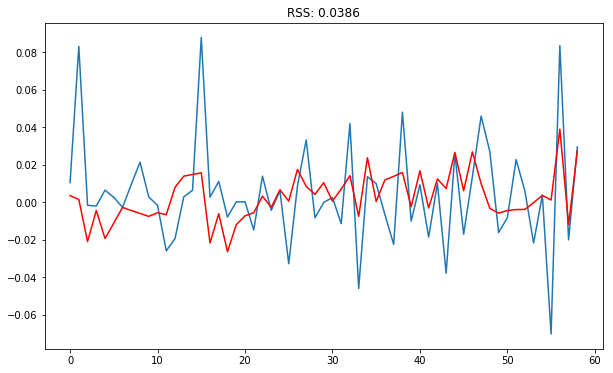


********** ARIMA Model for Log Transformed Data of SKU_04 **********


Best (p, d, q) Parameters: (0, 1, 2)

AIC Value: -237.1878485269552

*** RSS Plot between fitted model and shifted difference of Log Transform for SKU_04***



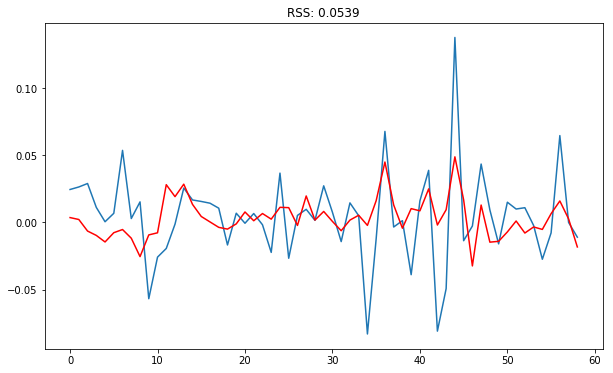


********** ARIMA Model for Log Transformed Data of SKU_05 **********


Best (p, d, q) Parameters: (1, 1, 1)

AIC Value: -225.8044198798311

*** RSS Plot between fitted model and shifted difference of Log Transform for SKU_05***



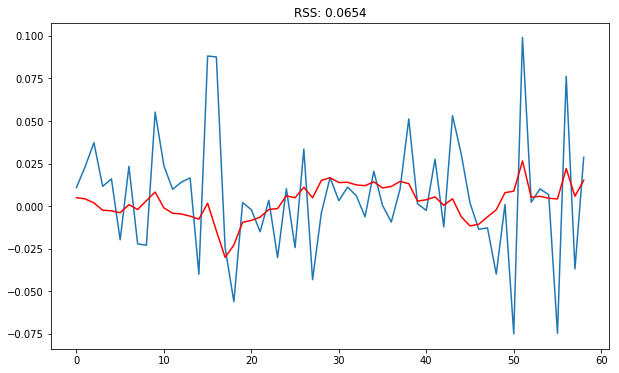

In [26]:
#Fit AIRMA model
models_fit = ARIMAtesting(sales_prom,sku)


## Model Fitting and Forecasting


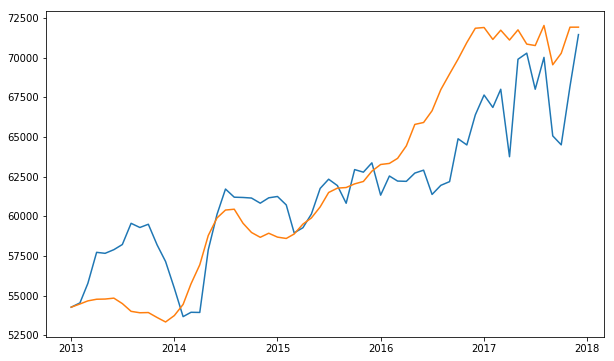

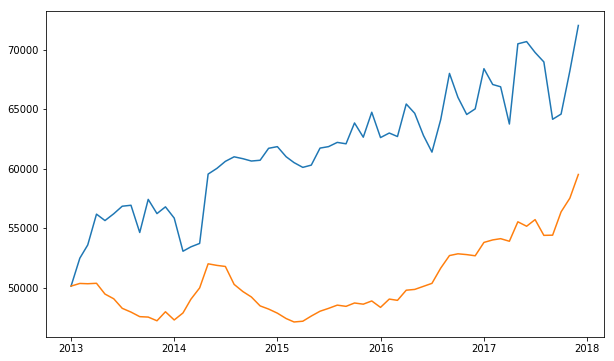

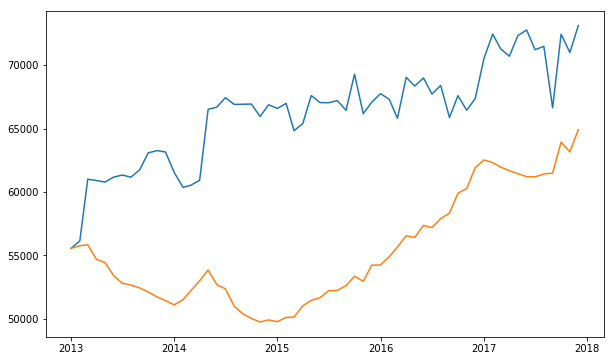

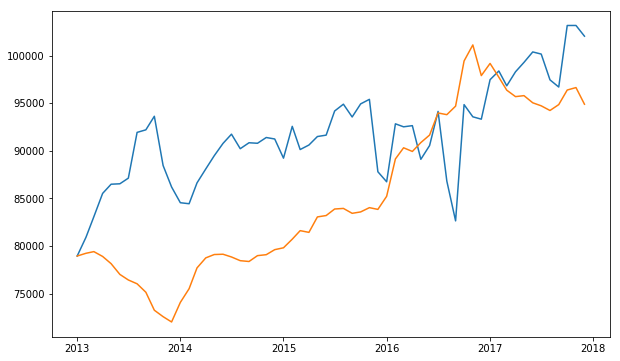

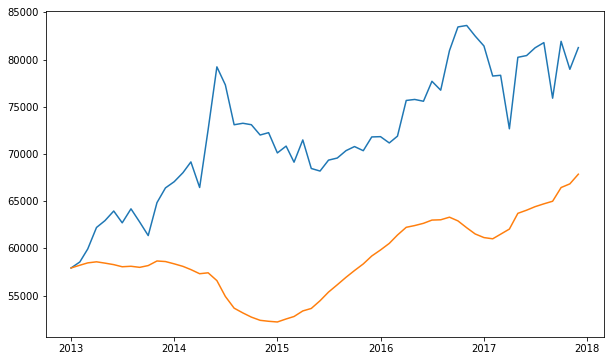

In [27]:
#Plot fitted model visualizations
fittedmodelsPlots(sales_prom,sku,models_fit)


********** 5 Year Forecast for the Log Transformed SKUs **********



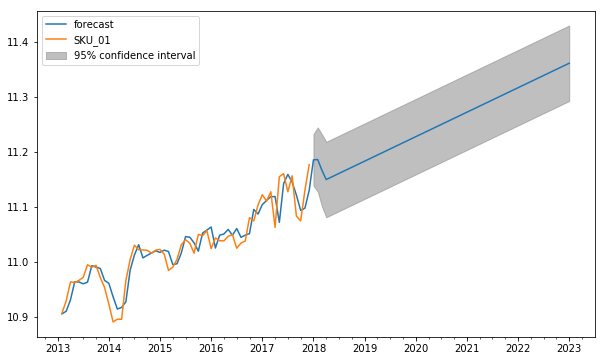

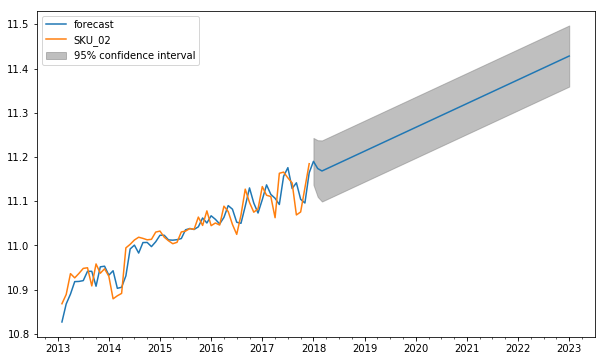

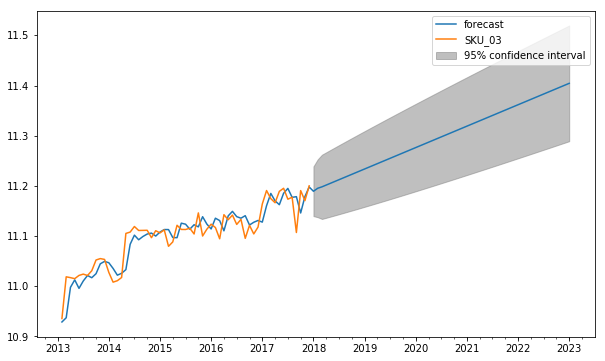

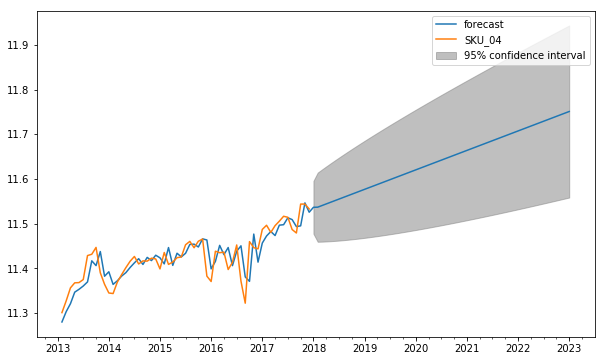

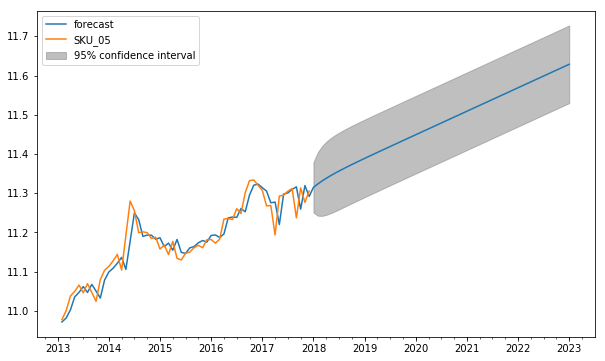

In [32]:
#Obtain Forecast list
f1,f2,f3,f4,f5, months = forecasts(models_fit,sku,months = 12*5)

forecasts_list = [f1,f2,f3,f4,f5]

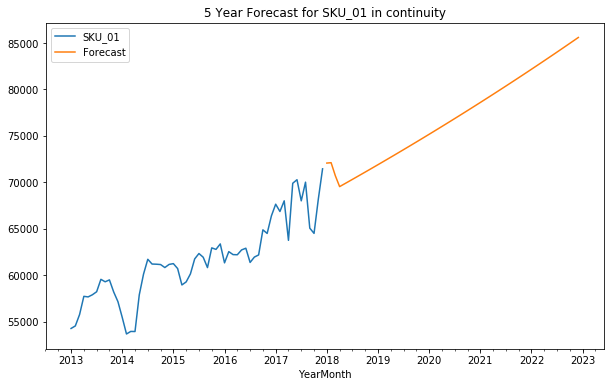

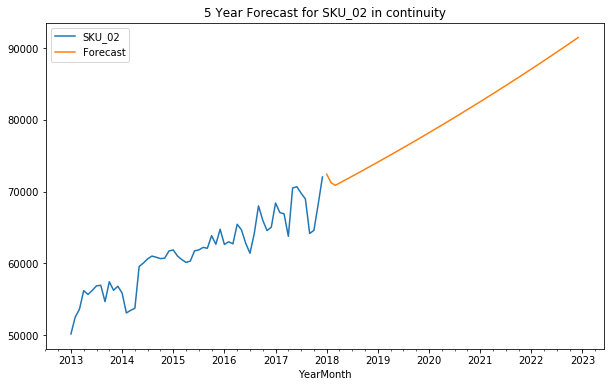

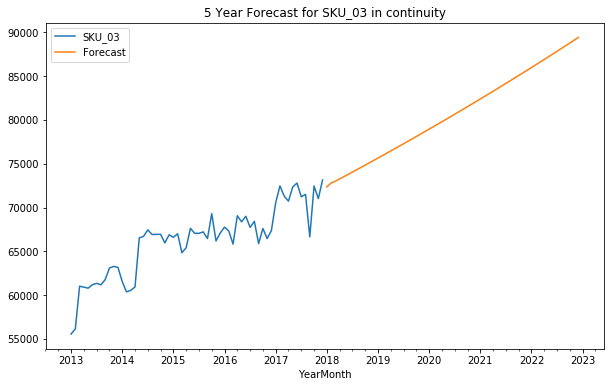

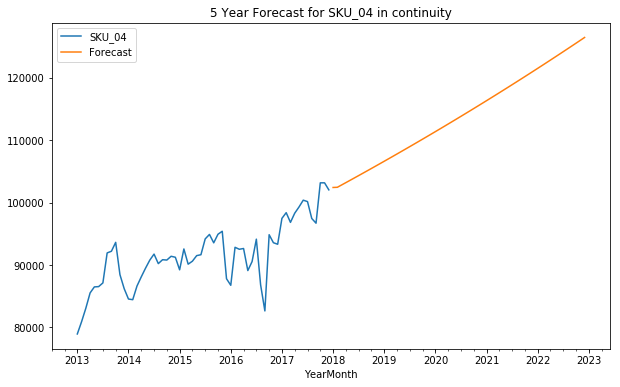

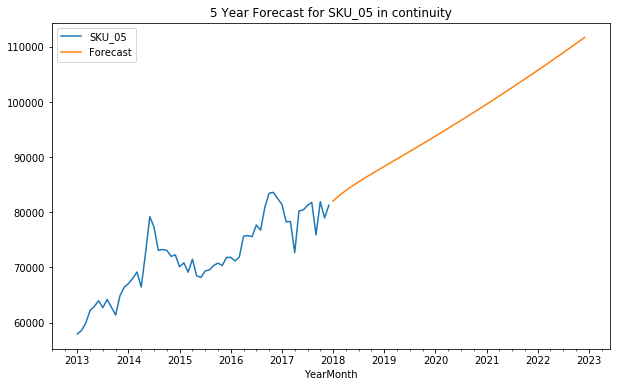

In [33]:
#Plot final forecasts
finalForecasts(sales_prom,sku,forecasts_list, months)